# Bag of Words Meets Bags of Popcorn

Filename: movie-review-model.ipynb \
Author: Timothy Holland \
Last updated: 14/06/2024 \
Kaggle competition: https://www.kaggle.com/c/word2vec-nlp-tutorial/data

## Data Summary

In [20]:
import pandas as pd

train_data = pd.read_csv('word2vec-nlp-tutorial/labeledTrainData.tsv', sep='\t')

# Load the test data
test_data = pd.read_csv('word2vec-nlp-tutorial/testData.tsv', sep='\t')

In [21]:
from collections import Counter

# Print the first few rows of the training data
print("First few rows of the training data:")
print(train_data.head())

# Get the total number of samples
total_train_samples = len(train_data)
total_test_samples = len(test_data)
print(f"\nTotal number of training samples: {total_train_samples}")
print(f"Total number of test samples: {total_test_samples}")

# Get the unique sentiments and their counts (only for training data)
sentiment_counts = Counter(train_data['sentiment'])
print("\nSentiment distribution (training data):")
for sentiment, count in sentiment_counts.items():
    print(f"{sentiment}: {count} ({count/total_train_samples*100:.2f}%)")

# Get the average length of the reviews
avg_train_review_length = train_data['review'].apply(len).mean()
avg_test_review_length = test_data['review'].apply(len).mean()
print(f"\nAverage training review length: {avg_train_review_length:.2f} characters")
print(f"Average test review length: {avg_test_review_length:.2f} characters")

# Get the number of unique words in the reviews (combining train and test data)
unique_words = set()
train_data['review'].str.lower().str.split().apply(unique_words.update)
test_data['review'].str.lower().str.split().apply(unique_words.update)
print(f"\nNumber of unique words (in both train and test): {len(unique_words)}")

# Print a random sample from the training data
print("\nRandom sample from training data:")
sample = train_data.sample().iloc[0]
print(f"ID: {sample['id']}")
print(f"Review: {sample['review'][:200]}...") # Print first 200 characters
print(f"Sentiment: {sample['sentiment']}")

# Calculate correlation between review length and sentiment (only for training data)
train_data['review_length'] = train_data['review'].apply(len)
correlation = train_data['review_length'].corr(train_data['sentiment'])
print(f"\nCorrelation between review length and sentiment (training data): {correlation:.4f}")

# Print the most common words (combining train and test data)
word_counts = Counter()
train_data['review'].str.lower().str.split().apply(word_counts.update)
test_data['review'].str.lower().str.split().apply(word_counts.update)
print("\nTop 10 most common words (in both train and test):")
for word, count in word_counts.most_common(10):
    print(f"{word}: {count}")

First few rows of the training data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...

Total number of training samples: 25000
Total number of test samples: 25000

Sentiment distribution (training data):
1: 12500 (50.00%)
0: 12500 (50.00%)

Average training review length: 1327.71 characters
Average test review length: 1296.44 characters

Number of unique words (in both train and test): 401572

Random sample from training data:
ID: 8922_4
Review: Two old men sitting on a park bench . I don`t really have a problem with this scene - Only problem is that it`s not a scene it`s the entire movie<br /><br />Yup movies

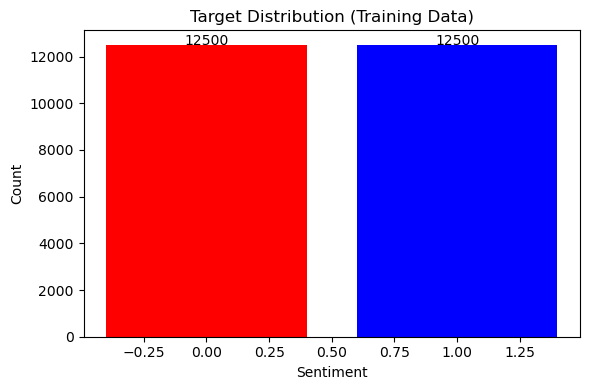

In [22]:
import pandas as pd
import matplotlib.pyplot as plt


# Count the number of positive and negative sentiments
sentiment_counts = train_data['sentiment'].value_counts()

# Create a bar plot
plt.figure(figsize=(6, 4))
plt.bar(sentiment_counts.index, sentiment_counts.values, color=['blue', 'red'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Target Distribution (Training Data)')
plt.xticks(rotation=0)

# Add count labels on top of the bars
for i, count in enumerate(sentiment_counts.values):
    plt.text(i, count + 0.1, str(count), ha='center')

plt.tight_layout()
plt.show()

## Data Processing

#### Lemmatising

In [23]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download necessary NLTK data (uncomment these lines if you haven't downloaded them before)
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

# Preprocessing functions
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize the text
    tokens = text.split()
    
    # Remove stopwords and lemmatize the tokens
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    
    # Join the tokens back into a string
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

# Apply the preprocessing function to the 'review' column for both train and test data
train_data['preprocessed_review'] = train_data['review'].apply(preprocess_text)
test_data['preprocessed_review'] = test_data['review'].apply(preprocess_text)

# Print the first few rows of the preprocessed training data
print("Preprocessed training data:")
print(train_data[['id', 'sentiment', 'preprocessed_review']].head())

# Print the first few rows of the preprocessed test data
print("\nPreprocessed test data:")
print(test_data[['id', 'preprocessed_review']].head())

Preprocessed training data:
       id  sentiment                                preprocessed_review
0  5814_8          1  stuff going moment mj ive started listening mu...
1  2381_9          1  classic war world timothy hines entertaining f...
2  7759_3          0  film start manager nicholas bell giving welcom...
3  3630_4          0  must assumed praised film greatest filmed oper...
4  9495_8          1  superbly trashy wondrously unpretentious explo...

Preprocessed test data:
         id                                preprocessed_review
0  12311_10  naturally film who main theme mortality nostal...
1    8348_2  movie disaster within disaster film full great...
2    5828_4  movie kid saw tonight child loved one point ki...
3    7186_2  afraid dark left impression several different ...
4   12128_7  accurate depiction small time mob life filmed ...


#### Embedding

In [31]:
import pandas as pd
from gensim.models import Word2Vec
import numpy as np

# Combine preprocessed reviews from both train and test data and train Word2Vec
all_sentences = [review.split() for review in train_data['preprocessed_review']] + \
                [review.split() for review in test_data['preprocessed_review']]

# Train Word2Vec model on all data
wv_model = Word2Vec(all_sentences, vector_size=100, window=5, min_count=1, workers=4)

# Derives average word vector
def get_average_word_vector(words, wv_model, num_features):
    feature_vector = np.zeros((num_features,), dtype="float32")
    n_words = 0
    for word in words:
        if word in wv_model.wv:
            n_words += 1
            feature_vector = np.add(feature_vector, wv_model.wv[word])
    if n_words > 0:
        feature_vector = np.divide(feature_vector, n_words)
    return feature_vector

# Disply embedding
print("Vocabulary size:", len(wv_model.wv.key_to_index))
print("\nDimensions of word vectors:", wv_model.vector_size)

# Get average vector for a sample review from training data
sample_review = train_data['preprocessed_review'].iloc[0]
avg_vector = get_average_word_vector(sample_review.split(), wv_model, wv_model.vector_size)
print("\nAverage vector for a sample review (training data):")
print(avg_vector)

Vocabulary size: 164583

Dimensions of word vectors: 100

Average vector for a sample review (training data):
[ 0.3454607  -0.76045346 -0.6445386   0.17037821  0.7057858  -0.42541578
  0.35390985  0.8992364  -0.29709825 -0.19355714 -0.23803347  0.16181953
 -0.29369128  0.47638464 -0.50331724 -0.19965753  0.75265586  0.04059177
  0.3212627  -0.18724583 -0.1431749   0.14269477 -0.13043985  0.10722506
  0.7094499   0.18202609 -0.6648707   0.6041841   0.07008043  0.51935774
  0.71376157  0.10553159  0.56604695 -0.7547343  -0.28993243 -0.14655647
 -0.2199872  -0.6740094  -0.18566959 -0.6819774  -0.00466572 -0.7896425
  0.37749887  0.14884299 -0.04413852 -0.27660143 -0.37184426 -0.4048045
  0.04259172 -0.49762118  0.5319976  -0.10604243 -0.24538472 -0.6334416
 -0.06477802 -0.44244307 -0.04426922  0.29833964 -0.65162235 -0.07247707
  0.41037318  0.00268964  0.36071548 -0.1101363  -0.78956336  0.5041196
  0.60606617 -0.16907217 -0.8792943   0.10302988 -0.64841074 -0.42286906
  0.2623041  -0.07

#### Feature Vectors

Sentences into average embeddings

In [32]:
import numpy as np
import pandas as pd

# Feature vectors of each review in train & test
X_train_average = np.array([get_average_word_vector(review.split(), wv_model, wv_model.vector_size) for review in train_data['preprocessed_review']])
y_train = train_data['sentiment']

X_test_average = np.array([get_average_word_vector(review.split(), wv_model, wv_model.vector_size) for review in test_data['preprocessed_review']])

# Convert sentiment labels to binary (0 and 1) for training data
y_train = pd.get_dummies(y_train, drop_first=True).iloc[:, 0]

print("Shape of X_train:", X_train_average.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test_average.shape)

Shape of X_train: (25000, 100)
Shape of y_train: (25000,)
Shape of X_test: (25000, 100)


Sentences into composite embeddings

In [ ]:
import numpy as np

def create_input_matrix(reviews, wv_model, max_sequence_length):
    input_matrix = []
    
    for review in reviews:
        sequence = []
        for word in review:
            if word in wv_model.wv:
                sequence.append(wv_model.wv[word])
            else:
                sequence.append(np.zeros(wv_model.vector_size))
        
        if len(sequence) < max_sequence_length:
            padding = [np.zeros(wv_model.vector_size)] * (max_sequence_length - len(sequence))
            sequence.extend(padding)
        else:
            sequence = sequence[:max_sequence_length]
        
        input_matrix.append(sequence)
    
    return np.array(input_matrix)

# Set the maximum sequence length
max_sequence_length = 100

# Generate input matrices for training and testing data
X_train_sequences = create_input_matrix(train_data['preprocessed_review'], wv_model, max_sequence_length)
X_test_sequences = create_input_matrix(test_data['preprocessed_review'], wv_model, max_sequence_length)

# Get the sentiment labels for training and testing data
y_train = train_data['sentiment']

# Display information
print(X_train_sequences.shape)

## Models

#### KNN

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# Create the KNN classifier & grid search hyperparameters
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Derive best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f"Best hyperparameters: {best_params}")

#### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score

# Hyperparameters
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# Instantiate LR & grid search
model = LogisticRegression()

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

# Get the best model and its parameters
best_lr_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best parameters:", best_params)

# Evaluate the best model using cross-validation
cv_scores = cross_val_score(best_lr_model, X_train, y_train, cv=5, scoring='roc_auc')
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

# Fit best model
best_lr_model.fit(X_train, y_train)

In [ ]:
y_pred_prob = best_lr_model.predict_proba(X_test)[:, 1]
best_model = best_lr_model

#### Support Vector Machine

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer

# Create an SVM classifier
svm_classifier = SVC(kernel='rbf', random_state=42, probability=True)
roc_auc_scorer = make_scorer(roc_auc_score)

# Perform cross-validation
cv_scores = cross_val_score(svm_classifier, X_train, y_train, cv=5, scoring=roc_auc_scorer)
print("Cross-validation scores:", cv_scores)
print(f"Mean ROC AUC: {cv_scores.mean():.2f}")
print(f"Standard deviation: {cv_scores.std():.2f}")

#### MLP
Utilises padded embedded sentences.

In [60]:
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense, Dropout
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score

# Define the model architecture
def create_model():
    model = Sequential()
    model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2), input_shape=(max_sequence_length, wv_model.vector_size)))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Create the model
mlp_model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=1)

# Evaluate the model using cross-validation
cv_scores = cross_val_score(mlp_model, X_train, y_train, cv=5)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

ValueError: Found input variables with inconsistent numbers of samples: [20000, 25000]

In [ ]:
print("X_train_padded shape:", X_train_padded.shape)
print("y_train shape:", y_train.shape)

In [52]:
best_model = model

## Predictions

In [54]:
import csv

# Predictions & conversions for submission
y_pred = best_model.predict(X_test_padded)
y_pred_int = y_pred.astype(int)

submission_df = pd.DataFrame({'id': test_data['id'], 'sentiment': y_pred_int})
submission_df['id'] = submission_df['id'].astype(str)

# Save the predictions to a CSV file
submission_df.to_csv('submission.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)
print("Predictions saved to 'submission.csv'")

782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step


ValueError: Per-column arrays must each be 1-dimensional